# Task 1 – Preprocess & Explore the Data

**Assets:** TSLA, BND, SPY  
**Period:** 2015-01-01 → 2026-01-15  
**Source:** YFinance

### Sections
1. Data Extraction
2. Cleaning & Quality Check
3. Exploratory Data Analysis (EDA)
4. Stationarity Tests (ADF)
5. Risk Metrics (VaR, Sharpe Ratio)
6. Save Stats & Figures

In [2]:
# ── Imports ──────────────────────────────────────────────────────────────────
from __future__ import annotations

import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

# ── Paths ─────────────────────────────────────────────────────────────────────
ROOT = Path("..")
DATA_DIR = ROOT / "data" / "processed"
IMG_DIR = Path("images")
DATA_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# ── Plot style ────────────────────────────────────────────────────────────────
sns.set_theme(style="darkgrid", palette="tab10")
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (12, 5)})

# ── Constants ─────────────────────────────────────────────────────────────────
TICKERS: list[str] = ["TSLA", "BND", "SPY"]
START: str = "2015-01-01"
END: str = "2026-01-15"
TRADING_DAYS: int = 252

print("Setup complete.")

Setup complete.


## 1. Data Extraction

In [3]:
# ── Fetch raw data from YFinance ──────────────────────────────────────────────
raw: dict[str, pd.DataFrame] = {}

for ticker in TICKERS:
    df = yf.download(ticker, start=START, end=END, auto_adjust=True, progress=False)
    df.index = pd.to_datetime(df.index)
    raw[ticker] = df
    print(f"{ticker}: {len(df):,} rows  |  {df.index.min().date()} → {df.index.max().date()}")

# Peek at TSLA
raw["TSLA"].head()

TSLA: 2,775 rows  |  2015-01-02 → 2026-01-14
BND: 2,775 rows  |  2015-01-02 → 2026-01-14
SPY: 2,775 rows  |  2015-01-02 → 2026-01-14


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [4]:
# ── Save raw CSVs ─────────────────────────────────────────────────────────────
for ticker, df in raw.items():
    path = DATA_DIR / f"{ticker}_raw.csv"
    df.to_csv(path)
    print(f"Saved {path}")

Saved ../data/processed/TSLA_raw.csv
Saved ../data/processed/BND_raw.csv
Saved ../data/processed/SPY_raw.csv


## 2. Cleaning & Quality Check

In [5]:
# ── Basic statistics ──────────────────────────────────────────────────────────
for ticker, df in raw.items():
    print(f"\n{'='*50}")
    print(f"  {ticker}")
    print(f"{'='*50}")
    print(df.describe().round(4))


  TSLA
Price       Close       High        Low       Open        Volume
Ticker       TSLA       TSLA       TSLA       TSLA          TSLA
count   2775.0000  2775.0000  2775.0000  2775.0000  2.775000e+03
mean     138.4729   141.5341   135.2712   138.5059  1.108480e+08
std      131.6821   134.6163   128.6688   131.7913  7.145365e+07
min        9.5780    10.3313     9.4033     9.4880  1.062000e+07
25%       17.8517    18.0870    17.5880    17.8367  6.758150e+07
50%       91.6260    94.4840    89.1140    93.0667  9.264600e+07
75%      242.0283   247.8467   236.9783   242.9017  1.282366e+08
max      489.8800   498.8300   485.3300   489.8800  9.140820e+08

  BND
Price       Close       High        Low       Open        Volume
Ticker        BND        BND        BND        BND           BND
count   2775.0000  2775.0000  2775.0000  2775.0000  2.775000e+03
mean      67.1035    67.2019    67.0030    67.1060  4.485148e+06
std        4.6698     4.6767     4.6608     4.6697  2.918896e+06
min       

In [6]:
# ── Missing value audit ───────────────────────────────────────────────────────
print("Missing values per ticker:")
for ticker, df in raw.items():
    nulls = df.isnull().sum()
    print(f"\n{ticker}:")
    print(nulls[nulls > 0] if nulls.any() else "  None")

Missing values per ticker:

TSLA:
  None

BND:
  None

SPY:
  None


In [7]:
# ── Clean: forward-fill then back-fill residual NaNs ─────────────────────────
clean: dict[str, pd.DataFrame] = {}

for ticker, df in raw.items():
    df_c = df.copy()
    df_c = df_c.ffill().bfill()
    # Ensure correct dtypes
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        if col in df_c.columns:
            df_c[col] = df_c[col].astype(float)
    clean[ticker] = df_c

# Verify no remaining NaNs
for ticker, df in clean.items():
    assert df.isnull().sum().sum() == 0, f"{ticker} still has NaNs!"
print("All clean — no missing values.")

All clean — no missing values.


In [8]:
# ── Save cleaned CSVs ─────────────────────────────────────────────────────────
for ticker, df in clean.items():
    path = DATA_DIR / f"{ticker}_clean.csv"
    df.to_csv(path)
    print(f"Saved {path}")

Saved ../data/processed/TSLA_clean.csv
Saved ../data/processed/BND_clean.csv
Saved ../data/processed/SPY_clean.csv


## 3. Exploratory Data Analysis (EDA)

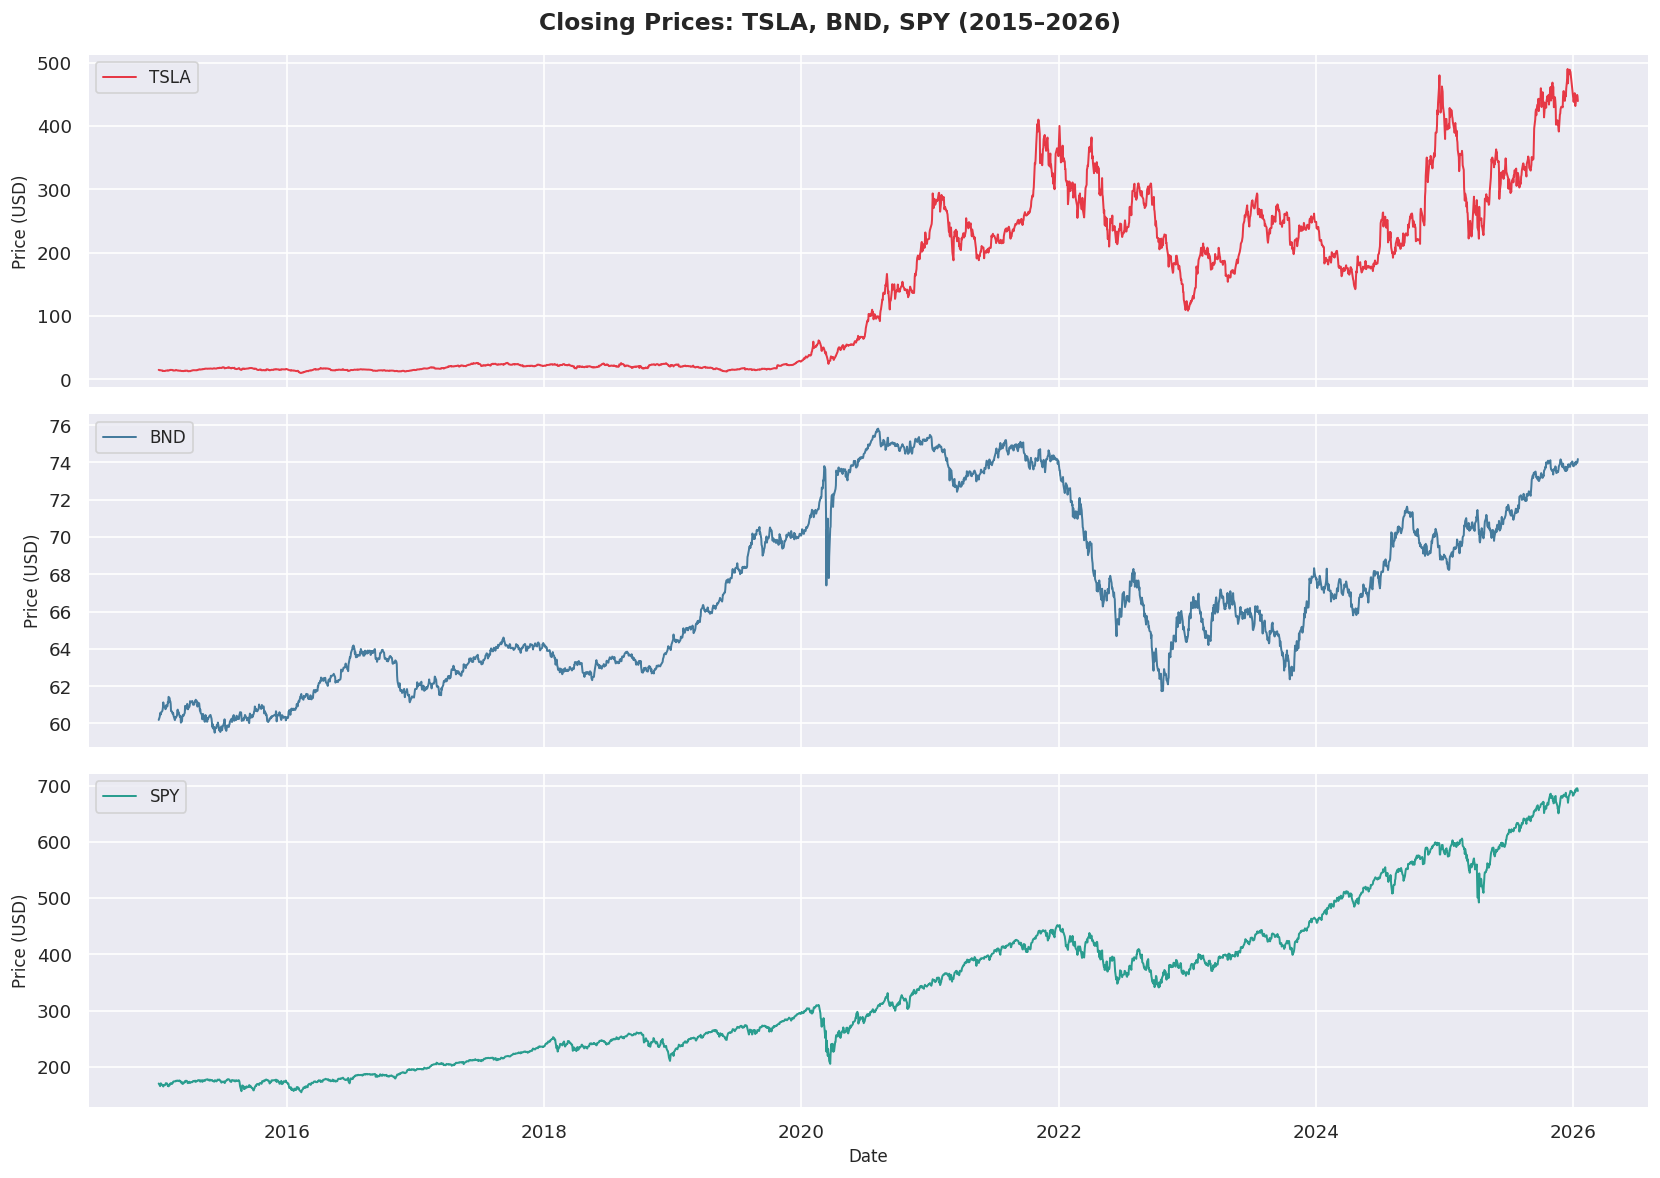

Saved fig1_closing_prices.png


In [9]:
# ── Fig 1: Closing prices over time ──────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
colors = ["#E63946", "#457B9D", "#2A9D8F"]

for ax, (ticker, df), color in zip(axes, clean.items(), colors):
    close = df["Close"].squeeze()
    ax.plot(close.index, close.values, color=color, linewidth=1.2, label=ticker)
    ax.set_ylabel("Price (USD)", fontsize=10)
    ax.legend(loc="upper left", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[-1].set_xlabel("Date", fontsize=10)
fig.suptitle("Closing Prices: TSLA, BND, SPY (2015–2026)", fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(IMG_DIR / "fig1_closing_prices.png", bbox_inches="tight")
plt.show()
print("Saved fig1_closing_prices.png")

In [10]:
# ── Compute daily returns ─────────────────────────────────────────────────────
returns: dict[str, pd.Series] = {}
for ticker, df in clean.items():
    close = df["Close"].squeeze()
    returns[ticker] = close.pct_change().dropna()

returns_df = pd.DataFrame(returns)
print("Daily returns shape:", returns_df.shape)
returns_df.describe().round(6)

Daily returns shape: (2774, 3)


,TSLA,BND,SPY
count,2774.000000,2774.000000,2774.000000
mean,0.001885,0.000081,0.000567
std,0.036343,0.003374,0.011193
min,-0.210628,-0.054385,-0.109424
25%,-0.016545,-0.001517,-0.003692
50%,0.001244,0.000127,0.000645
75%,0.019571,0.001773,0.005929
max,0.226900,0.042201,0.105019


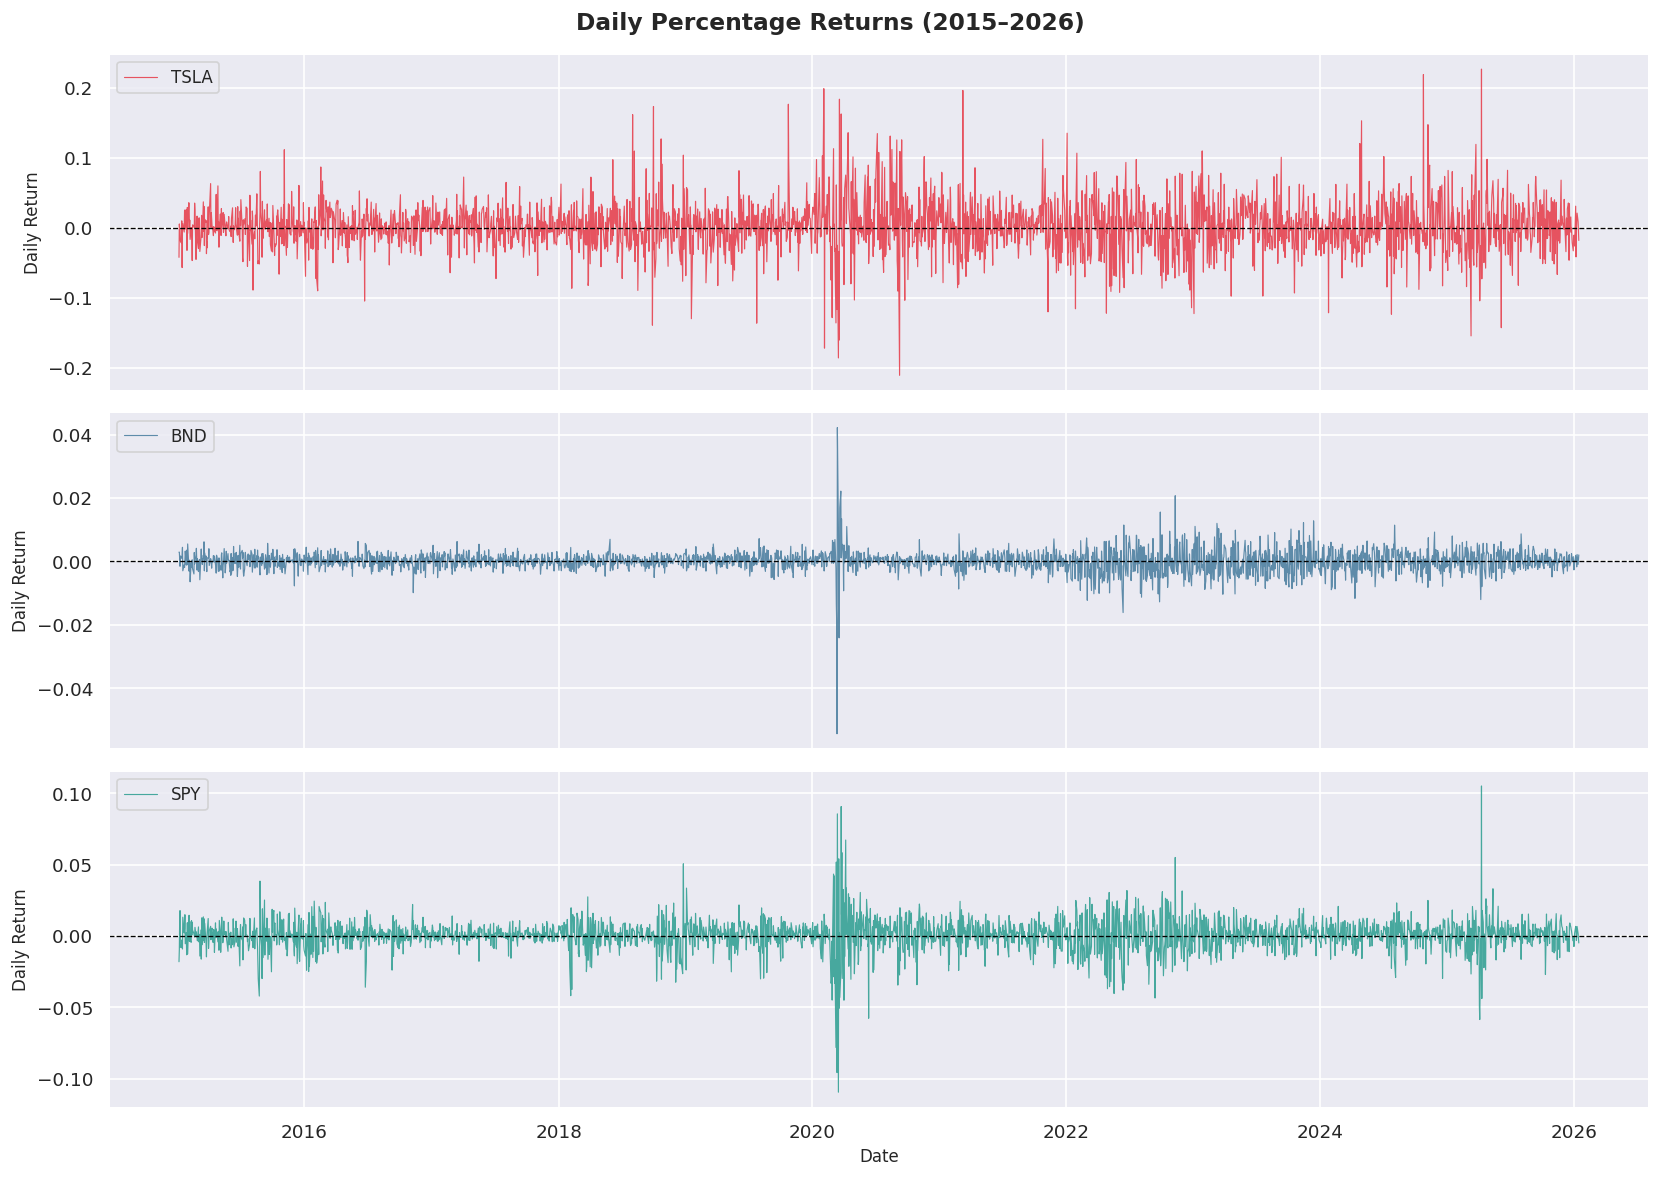

Saved fig2_daily_returns.png


In [11]:
# ── Fig 2: Daily returns ──────────────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for ax, (ticker, ret), color in zip(axes, returns.items(), colors):
    ax.plot(ret.index, ret.values, color=color, linewidth=0.7, alpha=0.85, label=ticker)
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax.set_ylabel("Daily Return", fontsize=10)
    ax.legend(loc="upper left", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[-1].set_xlabel("Date", fontsize=10)
fig.suptitle("Daily Percentage Returns (2015–2026)", fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(IMG_DIR / "fig2_daily_returns.png", bbox_inches="tight")
plt.show()
print("Saved fig2_daily_returns.png")

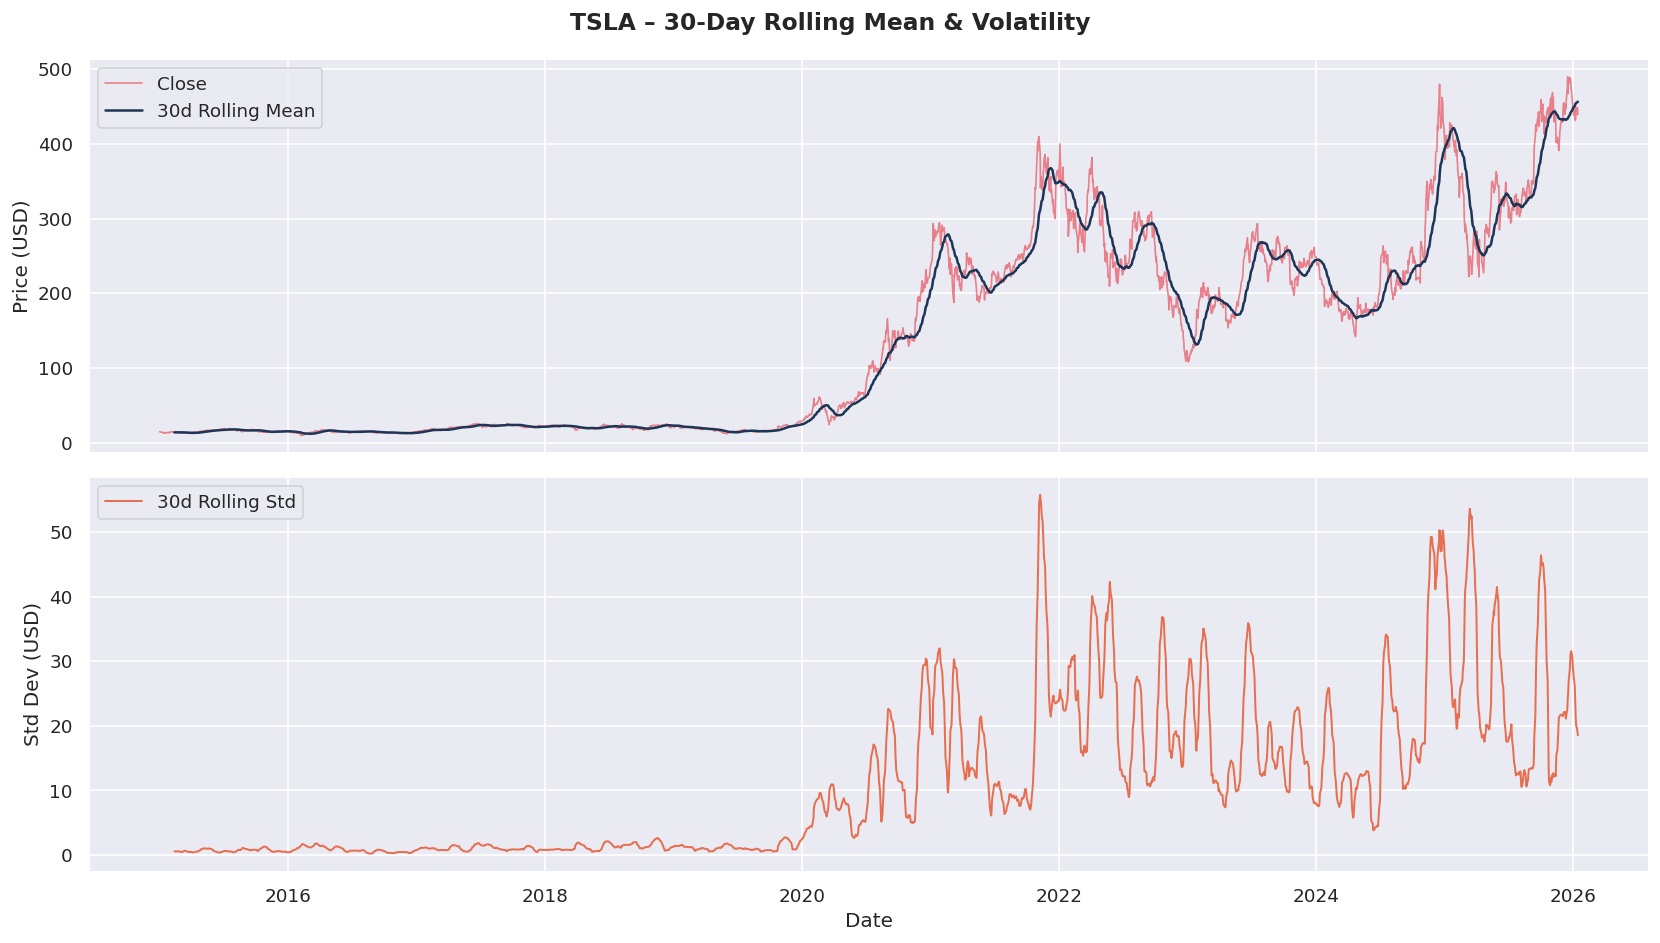

Saved fig3_tsla_rolling_stats.png


In [12]:
# ── Fig 3: Rolling 30-day mean & std (TSLA focus) ────────────────────────────
tsla_close = clean["TSLA"]["Close"].squeeze()
roll_mean = tsla_close.rolling(30).mean()
roll_std = tsla_close.rolling(30).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(tsla_close.index, tsla_close.values, color="#E63946", linewidth=1, alpha=0.6, label="Close")
ax1.plot(roll_mean.index, roll_mean.values, color="#1D3557", linewidth=1.5, label="30d Rolling Mean")
ax1.set_ylabel("Price (USD)")
ax1.legend()

ax2.plot(roll_std.index, roll_std.values, color="#E76F51", linewidth=1.2, label="30d Rolling Std")
ax2.set_ylabel("Std Dev (USD)")
ax2.set_xlabel("Date")
ax2.legend()

fig.suptitle("TSLA – 30-Day Rolling Mean & Volatility", fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(IMG_DIR / "fig3_tsla_rolling_stats.png", bbox_inches="tight")
plt.show()
print("Saved fig3_tsla_rolling_stats.png")

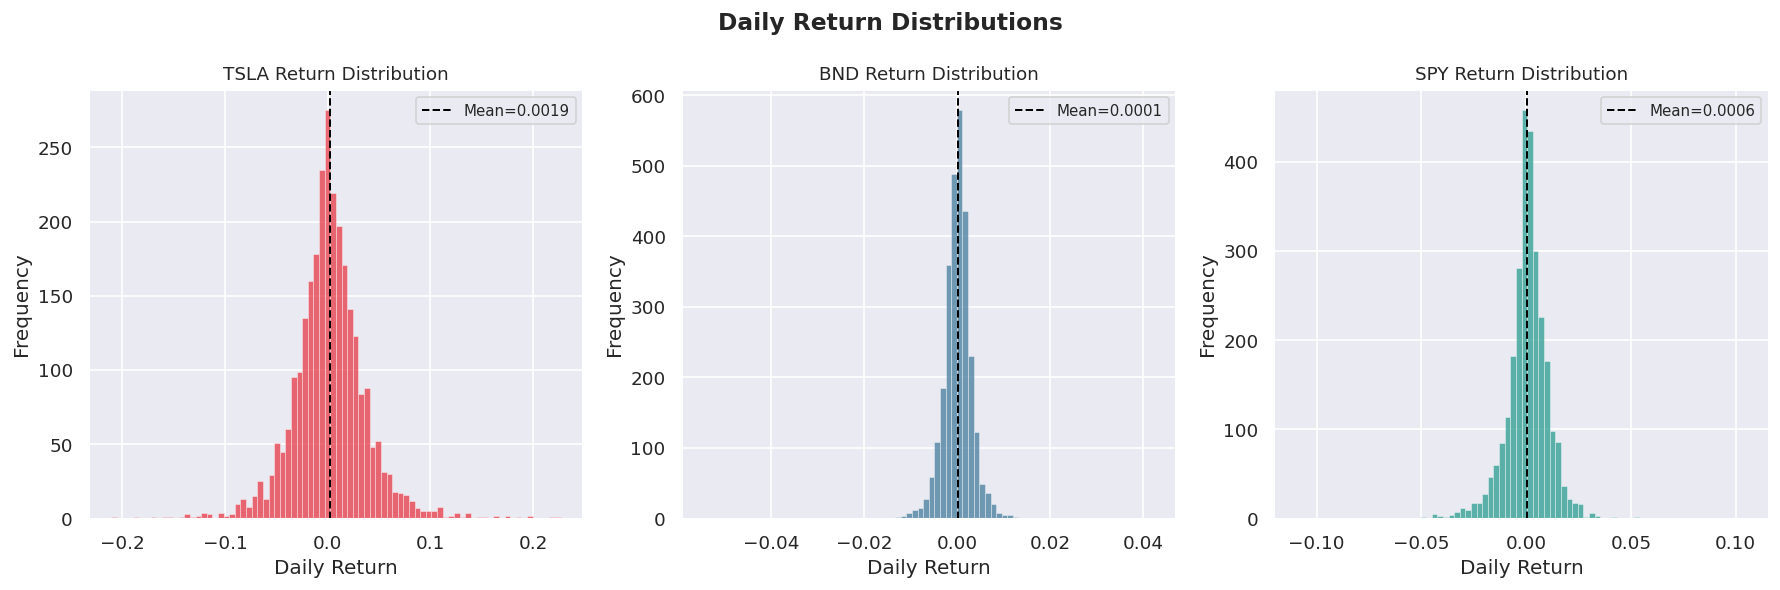

Saved fig4_return_distributions.png


In [13]:
# ── Fig 4: Return distribution histograms ────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (ticker, ret), color in zip(axes, returns.items(), colors):
    ax.hist(ret.values, bins=80, color=color, alpha=0.75, edgecolor="white", linewidth=0.3)
    ax.axvline(ret.mean(), color="black", linestyle="--", linewidth=1.2, label=f"Mean={ret.mean():.4f}")
    ax.set_title(f"{ticker} Return Distribution", fontsize=11)
    ax.set_xlabel("Daily Return")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=9)

fig.suptitle("Daily Return Distributions", fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(IMG_DIR / "fig4_return_distributions.png", bbox_inches="tight")
plt.show()
print("Saved fig4_return_distributions.png")

In [14]:
# ── Outlier detection: days with |return| > 3 std ────────────────────────────
print("Extreme return days (|return| > 3σ):\n")
outlier_summary: dict[str, dict] = {}

for ticker, ret in returns.items():
    threshold = 3 * ret.std()
    outliers = ret[ret.abs() > threshold].sort_values(key=abs, ascending=False)
    outlier_summary[ticker] = {
        "count": len(outliers),
        "threshold": round(float(threshold), 6),
        "top5": outliers.head(5).round(6).to_dict(),
    }
    print(f"{ticker}: {len(outliers)} outlier days (threshold ±{threshold:.4f})")
    print(outliers.head(5).to_string(), "\n")

Extreme return days (|return| > 3σ):

TSLA: 48 outlier days (threshold ±0.1090)
Date
2025-04-09    0.226900
2024-10-24    0.219190
2020-09-08   -0.210628
2020-02-03    0.198949
2021-03-09    0.196412 

BND: 31 outlier days (threshold ±0.0101)
Date
2020-03-12   -0.054385
2020-03-13    0.042201
2020-03-18   -0.024140
2020-03-23    0.022149
2022-11-10    0.020702 

SPY: 36 outlier days (threshold ±0.0336)
Date
2020-03-16   -0.109424
2025-04-09    0.105019
2020-03-12   -0.095677
2020-03-24    0.090603
2020-03-13    0.085486 



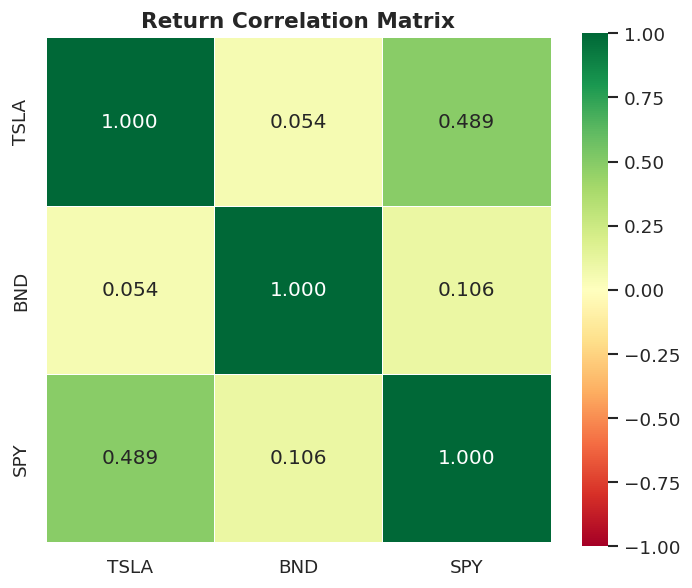

Saved fig5_correlation_heatmap.png


In [15]:
# ── Fig 5: Correlation heatmap of daily returns ───────────────────────────────
fig, ax = plt.subplots(figsize=(6, 5))
corr = returns_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    corr, annot=True, fmt=".3f", cmap="RdYlGn",
    center=0, vmin=-1, vmax=1, ax=ax,
    linewidths=0.5, square=True
)
ax.set_title("Return Correlation Matrix", fontsize=13, fontweight="bold")
plt.tight_layout()
fig.savefig(IMG_DIR / "fig5_correlation_heatmap.png", bbox_inches="tight")
plt.show()
print("Saved fig5_correlation_heatmap.png")

## 4. Stationarity Tests (ADF)

In [16]:
# ── Augmented Dickey-Fuller test ──────────────────────────────────────────────
def run_adf(series: pd.Series, label: str) -> dict:
    """Run ADF test and return a result dict."""
    result = adfuller(series.dropna(), autolag="AIC")
    stat, p_value, _, _, critical_values, _ = result
    is_stationary = p_value < 0.05
    print(f"  {label}")
    print(f"    ADF Statistic : {stat:.4f}")
    print(f"    p-value       : {p_value:.6f}")
    print(f"    Critical (5%) : {critical_values['5%']:.4f}")
    print(f"    Stationary    : {'✓ YES' if is_stationary else '✗ NO'}\n")
    return {
        "adf_stat": round(float(stat), 6),
        "p_value": round(float(p_value), 8),
        "critical_5pct": round(float(critical_values["5%"]), 6),
        "is_stationary": bool(is_stationary),
    }

adf_results: dict[str, dict] = {}

for ticker, df in clean.items():
    close = df["Close"].squeeze()
    ret = returns[ticker]
    print(f"{'─'*50}")
    print(f"  {ticker}")
    print(f"{'─'*50}")
    adf_results[ticker] = {
        "close_price": run_adf(close, "Closing Price"),
        "daily_return": run_adf(ret, "Daily Return"),
    }

──────────────────────────────────────────────────
  TSLA
──────────────────────────────────────────────────
  Closing Price
    ADF Statistic : -0.7802
    p-value       : 0.824881
    Critical (5%) : -2.8626
    Stationary    : ✗ NO

  Daily Return
    ADF Statistic : -53.0196
    p-value       : 0.000000
    Critical (5%) : -2.8626
    Stationary    : ✓ YES

──────────────────────────────────────────────────
  BND
──────────────────────────────────────────────────
  Closing Price
    ADF Statistic : -1.0514
    p-value       : 0.734066
    Critical (5%) : -2.8626
    Stationary    : ✗ NO

  Daily Return
    ADF Statistic : -10.4337
    p-value       : 0.000000
    Critical (5%) : -2.8626
    Stationary    : ✓ YES

──────────────────────────────────────────────────
  SPY
──────────────────────────────────────────────────
  Closing Price
    ADF Statistic : 1.1709
    p-value       : 0.995778
    Critical (5%) : -2.8626
    Stationary    : ✗ NO

  Daily Return
    ADF Statistic : -17.

In [17]:
# ── ADF interpretation summary ────────────────────────────────────────────────
print("\nInterpretation:")
print("  Closing prices are typically NON-stationary (unit root present).")
print("  Daily returns are typically STATIONARY (mean-reverting).")
print("  For ARIMA, we use 'd=1' (first difference) to make prices stationary.")


Interpretation:
  Closing prices are typically NON-stationary (unit root present).
  Daily returns are typically STATIONARY (mean-reverting).
  For ARIMA, we use 'd=1' (first difference) to make prices stationary.


## 5. Risk Metrics

In [18]:
# ── Value at Risk (VaR) – Historical Simulation at 95% confidence ─────────────
RISK_FREE_RATE: float = 0.04  # annualized, ~10yr Treasury

risk_metrics: dict[str, dict] = {}

print(f"{'Ticker':<8} {'Ann. Return':>12} {'Ann. Volatility':>16} {'Sharpe Ratio':>13} {'VaR 95% (daily)':>16}")
print("-" * 70)

for ticker, ret in returns.items():
    ann_return: float = float(ret.mean() * TRADING_DAYS)
    ann_vol: float = float(ret.std() * np.sqrt(TRADING_DAYS))
    sharpe: float = (ann_return - RISK_FREE_RATE) / ann_vol if ann_vol != 0 else 0.0
    var_95: float = float(np.percentile(ret.dropna(), 5))  # 5th percentile = 95% VaR

    risk_metrics[ticker] = {
        "ann_return": round(ann_return, 6),
        "ann_volatility": round(ann_vol, 6),
        "sharpe_ratio": round(sharpe, 6),
        "var_95_daily": round(var_95, 6),
    }

    print(f"{ticker:<8} {ann_return:>12.4f} {ann_vol:>16.4f} {sharpe:>13.4f} {var_95:>16.4f}")

Ticker    Ann. Return  Ann. Volatility  Sharpe Ratio  VaR 95% (daily)
----------------------------------------------------------------------
TSLA           0.4749           0.5769        0.7539          -0.0525
BND            0.0204           0.0536       -0.3653          -0.0048
SPY            0.1429           0.1777        0.5789          -0.0167


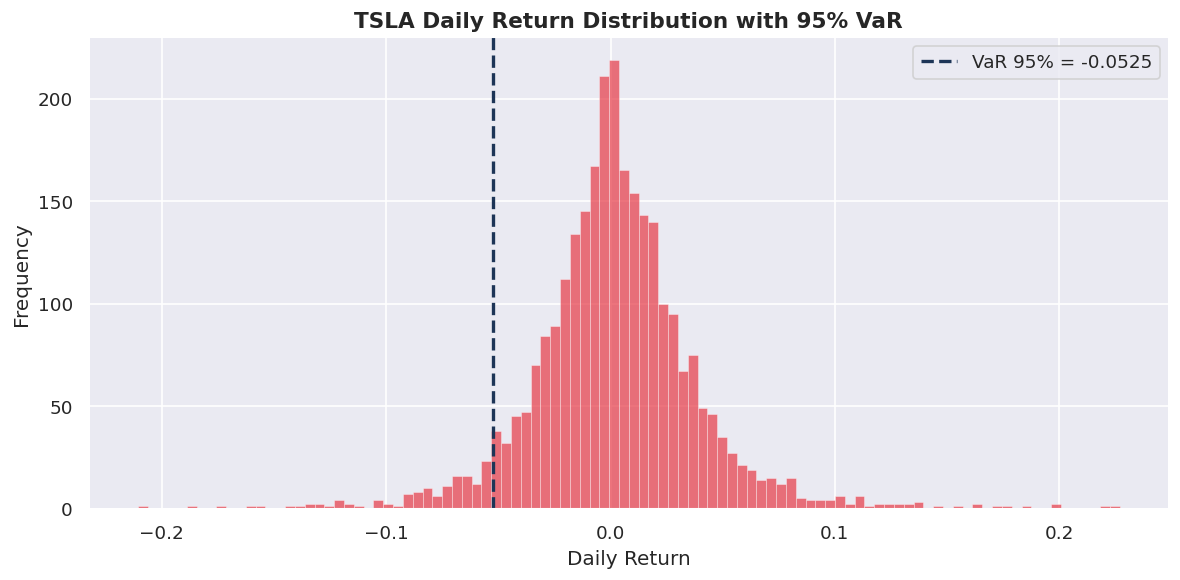

Saved fig6_tsla_var.png


In [19]:
# ── Fig 6: VaR visualisation for TSLA ────────────────────────────────────────
tsla_ret = returns["TSLA"]
var_95_tsla = risk_metrics["TSLA"]["var_95_daily"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tsla_ret.values, bins=100, color="#E63946", alpha=0.7, edgecolor="white", linewidth=0.3)
ax.axvline(var_95_tsla, color="#1D3557", linestyle="--", linewidth=2,
           label=f"VaR 95% = {var_95_tsla:.4f}")
ax.set_title("TSLA Daily Return Distribution with 95% VaR", fontsize=13, fontweight="bold")
ax.set_xlabel("Daily Return")
ax.set_ylabel("Frequency")
ax.legend(fontsize=11)
plt.tight_layout()
fig.savefig(IMG_DIR / "fig6_tsla_var.png", bbox_inches="tight")
plt.show()
print("Saved fig6_tsla_var.png")

## 6. Save Stats

In [20]:
# ── Persist all stats as JSON for use in reports ──────────────────────────────
stats: dict = {
    "period": {"start": START, "end": END},
    "tickers": TICKERS,
    "row_counts": {ticker: len(df) for ticker, df in clean.items()},
    "adf_results": adf_results,
    "risk_metrics": risk_metrics,
    "outlier_summary": {
        ticker: {
            "count": v["count"],
            "threshold": v["threshold"],
        }
        for ticker, v in outlier_summary.items()
    },
    "return_stats": {
        ticker: {
            "mean": round(float(ret.mean()), 8),
            "std": round(float(ret.std()), 8),
            "min": round(float(ret.min()), 8),
            "max": round(float(ret.max()), 8),
        }
        for ticker, ret in returns.items()
    },
}

stats_path = DATA_DIR / "task1_stats.json"
with open(stats_path, "w") as f:
    json.dump(stats, f, indent=2, default=str)

print(f"Stats saved → {stats_path}")
print(json.dumps(stats, indent=2, default=str))

Stats saved → ../data/processed/task1_stats.json
{
  "period": {
    "start": "2015-01-01",
    "end": "2026-01-15"
  },
  "tickers": [
    "TSLA",
    "BND",
    "SPY"
  ],
  "row_counts": {
    "TSLA": 2775,
    "BND": 2775,
    "SPY": 2775
  },
  "adf_results": {
    "TSLA": {
      "close_price": {
        "adf_stat": -0.780157,
        "p_value": 0.82488143,
        "critical_5pct": -2.862593,
        "is_stationary": false
      },
      "daily_return": {
        "adf_stat": -53.019619,
        "p_value": 0.0,
        "critical_5pct": -2.862583,
        "is_stationary": true
      }
    },
    "BND": {
      "close_price": {
        "adf_stat": -1.051382,
        "p_value": 0.73406596,
        "critical_5pct": -2.862587,
        "is_stationary": false
      },
      "daily_return": {
        "adf_stat": -10.433749,
        "p_value": 0.0,
        "critical_5pct": -2.862592,
        "is_stationary": true
      }
    },
    "SPY": {
      "close_price": {
        "adf_stat": 1.1708

## Summary

| Item | Finding |
|------|---------|
| Data quality | No missing values after forward-fill |
| TSLA closing price | Non-stationary (ADF p > 0.05) → requires d=1 for ARIMA |
| TSLA daily returns | Stationary (ADF p < 0.05) |
| TSLA Sharpe Ratio | See risk_metrics above |
| TSLA VaR 95% | See risk_metrics above — worst expected daily loss 95% of the time |
| Correlation | BND and SPY moderately correlated; TSLA low correlation with both |

**Key insight:** TSLA exhibits high volatility with fat tails (leptokurtic distribution), making it a high-risk, high-return asset. BND provides stability with low volatility. SPY sits in between. The non-stationarity of closing prices confirms we need differencing (d=1) for ARIMA in Task 2.